# online nets

Deep learning is powerful but computationally expensive, frequently requiring massive compute budgets. In persuit of cost-effective-yet-powerful AI, this work explores and evaluates a heuristic which should lend to more-efficient use of data through online learning.

Goal: evaluate a deep learning alternative capable of true online learning. Solution requirements:

1. catastrophic forgetting should be impossible;
2. all data is integrated into sufficient statistics of fixed dimension;
3. and our solution should have predictive power comparable to deep learning.

## modeling strategy

We will not attempt to derive sufficient statistics for an entire deep net, but instead leverage well-known sufficient statistics for least squares models, 
so will have sufficient statistics per deep net layer. If this can be empirically shown effective, we'll build-out the theory afterwards. 

Recognizing a deep net as a series of compositions, as follows.

$ Y + \varepsilon \approx \mathbb{E}Y = \sigma_3 \circ \beta_3^T \circ \sigma_2 \circ \beta_2^T \circ \sigma_1 \circ \beta_1^T X $

So, we can isolate invidivdual $\beta_j$ matrices using (psuedo-)inverses $\beta_j^{-1}$ like so.

$ \sigma_2^{-1} \circ \beta_3^{-1} \circ \sigma_3^{-1} (Y) \approx  \beta_2^T \circ \sigma_1 \circ \beta_1^T X $

In this example, if we freeze all $\beta_j$'s except $\beta_2$, we are free to update $\hat \beta_2$ using $\tilde Y = \sigma_2^{-1} \circ \beta_3^{-1} \circ \sigma_3^{-1} (Y) $
and $\tilde X = \sigma_1 \circ \beta_1^T X $.

Using a least squares formulation for fitting to $\left( \tilde X, \tilde Y \right)$, we get sufficient statistics per layer.

# model code definitions

In [36]:
import torch

TORCH_TENSOR_TYPE = type(torch.tensor(1)) 

def padded_diagonal(diag_value, n_rows, n_cols):
    ## construct diagonal matrix 
    n_diag = min(n_rows, n_cols)
    diag = torch.diag(torch.tensor([diag_value]*n_diag))
    if n_rows > n_cols: 
        ## pad rows 
        pad = n_rows - n_cols 
        return torch.cat([diag, torch.zeros((pad, n_cols))], 0)
    if n_cols > n_rows:
        ## pad cols 
        pad = n_cols - n_rows 
        return torch.cat([diag, torch.zeros((n_rows, pad))], 1)
    ## no padding 
    return diag 

class OnlineDenseLayer:
    '''
    A single dense net, formulated as a least squares model. 
    '''
    def __init__(self, p, q, activation=lambda x:x, activation_inverse=lambda x:x, lam=1.): 
        '''
        inputs:
        - p: input dimension
        - q: output dimension
        - activation: non-linear function, from R^p to R^q. Default is identity
        - activation_inverse: inverse of the activation function. Default is identity. 
        - lam: regularization term 
        '''
        self.__validate_inputs(p=p, q=q, lam=lam) 
        self.p = p 
        self.q = q 
        self.activation = activation 
        self.activation_inverse = activation_inverse 
        self.lam = lam 
        self.xTy = padded_diagonal(lam, p+1,q) # +1 for intercept 
        self.yTx = padded_diagonal(lam, q+1,p) 
        self.xTx_inv = torch.diag(torch.tensor([1./lam]*(p+1))) 
        self.yTy_inv = torch.diag(torch.tensor([1./lam]*(q+1))) 
        self.betaT_forward = torch.matmul(self.xTx_inv, self.xTy) 
        self.betaT_forward = torch.transpose(self.betaT_forward, 0, 1) 
        self.betaT_backward = torch.matmul(self.yTy_inv, self.yTx) 
        self.betaT_backward = torch.transpose(self.betaT_backward, 0, 1) 
        self.x_forward = None 
        self.y_forward = None 
        self.x_backward = None 
        self.y_backward = None 
        pass 
    def forward(self, x): 
        'creates and stores x_forward and y_forward, then returns activation(y_forward)' 
        self.__validate_inputs(x=x, p=self.p) 
        self.x_forward = x 
        x = torch.cat((torch.tensor([[1.]]), x), dim=0) # intercept 
        self.y_forward = torch.matmul(self.betaT_forward, x) # predict 
        return self.activation(self.y_forward) 
    def backward(self, y): 
        'creates and stores x_backward and y_backward, then returns y_backward'
        y = self.activation_inverse(y) 
        self.__validate_inputs(y=y, q=self.q) 
        self.y_backward = y 
        y = torch.cat((torch.tensor([[1.]]), y), dim=0) 
        self.x_backward = torch.matmul(self.betaT_backward, y) 
        return self.x_backward 
    def forward_fit(self): 
        'uses x_forward and y_backward to update forward model, then returns Sherman Morrison denominator' 
        self.__validate_inputs(x=self.x_forward, y=self.y_backward, p=self.p, q=self.q) 
        x = torch.cat((torch.tensor([[1.]]), self.x_forward), dim=0) 
        self.xTx_inv, sm_denom = self.sherman_morrison(self.xTx_inv, x, x) 
        self.xTy += torch.matmul(x, torch.transpose(self.y_backward, 0, 1)) 
        self.betaT_forward = torch.matmul(self.xTx_inv, self.xTy) 
        self.betaT_forward = torch.transpose(self.betaT_forward, 0, 1) 
        return sm_denom 
    def backward_fit(self):
        'uses x_backward and y_forward to update backward model, then returns Sherman Morrison denominator'
        self.__validate_inputs(x=self.x_forward, y=self.y_backward, p=self.p, q=self.q) 
        y = torch.cat((torch.tensor([[1.]]), self.y_backward), dim=0) 
        self.yTy_inv, sm_denom = self.sherman_morrison(self.yTy_inv, y, y) 
        self.yTx += torch.matmul(y, torch.transpose(self.x_backward, 0, 1)) 
        self.betaT_backward = torch.matmul(self.yTy_inv, self.yTx) 
        self.betaT_backward = torch.transpose(self.betaT_backward, 0, 1) 
        return sm_denom 
    @staticmethod
    def sherman_morrison(inv_mat, vec1, vec2):
        '''
        applies Sherman Morrison updates, (mat + vec1 vec2^T)^{-1}
        inputs:
        - inv_mat: an inverted matrix 
        - vec1: a column vector 
        - vec2: a column vector 
        returns:
        - updated matrix
        - the Sherman Morrison denominator, for tracking numerical stability 
        '''
        v2t = torch.transpose(vec2, 0, 1)
        denominator = 1. + torch.matmul(torch.matmul(v2t, inv_mat), vec1) 
        numerator = torch.matmul(torch.matmul(inv_mat, vec1), torch.matmul(v2t, inv_mat)) 
        updated_inv_mat = inv_mat - numerator / denominator 
        return updated_inv_mat, float(denominator) 
    def __validate_inputs(self, p=None, q=None, lam=None, x=None, y=None): 
        'raises value exceptions if provided parameters are invalid'
        if q is not None:
            if not isinstance(q, int):
                raise ValueError('`q` must be int!')
            if q <= 0:
                raise ValueError('`q` must be greater than zero!')
        if p is not None:
            if not isinstance(p, int): 
                raise ValueError('`p` must be int!')
            if p <= 0: 
                raise ValueError('`p` must be greater than zero!')
        if lam is not None:
            if not (isinstance(lam, float) or isinstance(lam, int)):
                raise ValueError('`lam` must be float or int!')
            if lam < 0:
                raise ValueError('`lam` must be non-negative!')
        if x is not None and p is not None: 
            if type(x) != TORCH_TENSOR_TYPE:
                raise ValueError('`x` must be of type `torch.tensor`!') 
            if list(x.shape) != [p,1]: 
                raise ValueError('`x.shape` must be `[p,1]`!') 
            if torch.isnan(x).any():
                raise ValueError('`x` contains `nan`!')
            pass 
        if y is not None and q is not None: 
            if type(y) != TORCH_TENSOR_TYPE:
                raise ValueError('`y` must be of type `torch.tensor`!') 
            if list(y.shape) != [q,1]: 
                raise ValueError('`y.shape` must be `[q,1]`') 
            if torch.isnan(y).any():
                raise ValueError('`y` contains `nan`!')
            pass 
        pass 
    pass

class OnlineNet: 
    'online, sequential dense net' 
    def __init__(self, layer_list): 
        ## validate inputs 
        if type(layer_list) != list: 
            raise ValueError('`layer_list` must be of type list!') 
        for layer in layer_list: 
            if not issubclass(type(layer), OnlineDenseLayer):
                raise ValueError('each item in `layer_list` must be an instance of a subclass of `OnlineDenseLayer`!') 
        ## assign 
        self.layer_list = layer_list 
        pass 
    def forward(self, x): 
        'predict forward'
        for layer in self.layer_list:
            x = layer.forward(x) 
        return x 
    def backward(self, y):
        'predict backward'
        for layer in reversed(self.layer_list): 
            y = layer.backward(y) 
        return y 
    def fit(self): 
        'assumes layers x & y targets have already been set. Returns Sherman Morrison denominators per layer in (forward, backward) pairs in a list'
        sherman_morrison_denominator_list = [] 
        for layer in self.layer_list:
            forward_smd = layer.forward_fit() 
            backward_smd = layer.backward_fit() 
            sherman_morrison_denominator_list.append((forward_smd, backward_smd))
        return sherman_morrison_denominator_list 
    def __reduce_sherman_morrison_denominator_list(self, smd_pair_list):
        'returns the value closest to zero'
        if type(smd_pair_list) != list: 
            raise ValueError('`smd_pair_list` must be of type `list`!')
        if len(smd_pair_list) == 0:
            return None 
        smallest_smd = None 
        for smd_pair in smd_pair_list:
            if type(smd_pair) != tuple:
                raise ValueError('`smd_pair_list` must be list of tuples!')
            if smallest_smd is None: 
                smallest_smd = smd_pair[0] 
            if abs(smallest_smd) > abs(smd_pair[0]): 
                smallest_smd = smd_pair[0] 
            if abs(smallest_smd) > abs(smd_pair[1]):
                smallest_smd = smd_pair[1] 
        return float(smallest_smd) 
    def __call__(self, x, y=None): 
        '''
        If only x is given, a prediction is made and returned.
        If x and y are given, then the model is updated, and returns
        - the prediction
        - the sherman morrison denominator closest to zero, for tracking numerical stability
        '''
        y_hat = self.forward(x) 
        if y is None: 
            return y_hat 
        self.backward(y) 
        self.layer_list[0].x_forward = x 
        self.layer_list[0].x_backward = x 
        self.layer_list[-1].y_forward = y 
        self.layer_list[-1].y_backward = y 
        smd_pair_list = self.fit() 
        smallest_smd = self.__reduce_sherman_morrison_denominator_list(smd_pair_list) 
        return y_hat, smallest_smd 

## tests 

## test 1: sherman morrison 
a = torch.tensor([[2., 1.], [1., 2.]]) 
b = torch.tensor([[.1],[.2]]) 
sm_inv, _ = OnlineDenseLayer.sherman_morrison(torch.inverse(a),b,b) 
num_inv = torch.inverse(a+torch.matmul(b, torch.transpose(b,0,1))) 
err = float(torch.abs(sm_inv - num_inv).sum()) 
assert(err < 1e-5) 

# first experiment: mnist classification

In [37]:
from tqdm import tqdm
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('../../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1)
test_loader = torch.utils.data.DataLoader(dataset2)

n_labels = 10 

## activation functions 
## torch.sigmoid 
inv_sigmoid = lambda x: -torch.log((1/(x+1e-8))-1) 
leaky_relu_alpha = .1 
leaky_relu = lambda x: (x > 0)*x + (x <= 0)*x*leaky_relu_alpha 
inv_leaky_relu = lambda x: (x > 0)*x + (x <= 0)*x/leaky_relu_alpha 

model = OnlineNet(
    [
        #OnlineDenseLayer(p=1*1*28*28, q=1000, activation=torch.sigmoid, activation_inverse=inv_sigmoid),  
        #OnlineDenseLayer(p=1000, q=5000, activation=torch.sigmoid, activation_inverse=inv_sigmoid), 
        #OnlineDenseLayer(p=5000, q=100, activation=torch.sigmoid, activation_inverse=inv_sigmoid), 
        #OnlineDenseLayer(p=100, q=n_labels, activation=torch.sigmoid, activation_inverse=inv_sigmoid)
        OnlineDenseLayer(p=3, q=2, activation=leaky_relu, activation_inverse=inv_leaky_relu),
        OnlineDenseLayer(p=2, q=1)
    ] 
)

def build_data(image, label): 
    'format data from iterator for model' 
    y = torch.tensor([1. if int(label[0]) == idx else 0. for idx in range(n_labels)]) ## one-hot representation 
    x = image.reshape([-1]) ## flatten 
    ## shrink so sigmoid inverse is well-defined 
    y = y*.90 + .05 
    ## reshape to column vectors 
    x = x.reshape([-1,1]) 
    y = y.reshape([-1,1]) 
    return x, y 

def build_test_data():
    x = torch.normal(mean=torch.zeros([3,1]))
    y = torch.sigmoid(3. + 5.*x[0] - 10.*x[1])
    y = y + 3*x[2]
    y = y.reshape([-1,1])
    return x, y

errs = [] 
stab = [] 
pbar = tqdm(train_loader) 
for [image, label] in pbar: 
    #x, y = build_data(image, label) 
    x, y = build_test_data() 
    ## fit 
    y_hat, stability = model(x, y) 
    err = float((y - y_hat).abs().sum()) 
    errs.append(err) 
    stab.append(stability)
    pbar.set_description(f'err: {err}, stab: {stability}') 
    ## train error 
    ## TODO 

err: 4.8085551261901855, stab: 1.0005404949188232:   6%|▌         | 3586/60000 [00:07<01:50, 509.72it/s]   


KeyboardInterrupt: 

In [29]:
### DELETE ME 
y1 = model.layer_list[0].forward(x)
print(x)
print(y1)

x2 = model.layer_list[1].backward(y)
print(x2)

print(x)

tensor([[-1.5899],
        [-1.2096],
        [-1.4435]])
tensor([[0.],
        [0.]])
tensor([[0.],
        [0.]])
tensor([[-1.5899],
        [-1.2096],
        [-1.4435]])


In [30]:
### DELETE ME 
m2 = OnlineNet(
    [
        #OnlineDenseLayer(p=1*1*28*28, q=1000, activation=torch.sigmoid, activation_inverse=inv_sigmoid),  
        #OnlineDenseLayer(p=1000, q=5000, activation=torch.sigmoid, activation_inverse=inv_sigmoid), 
        #OnlineDenseLayer(p=5000, q=100, activation=torch.sigmoid, activation_inverse=inv_sigmoid), 
        #OnlineDenseLayer(p=100, q=n_labels, activation=torch.sigmoid, activation_inverse=inv_sigmoid)
        OnlineDenseLayer(p=3, q=2, activation=leaky_relu, activation_inverse=inv_leaky_relu),
        OnlineDenseLayer(p=2, q=1)
    ] 
)

m2.layer_list[0].forward(x)

tensor([[0.],
        [0.]])

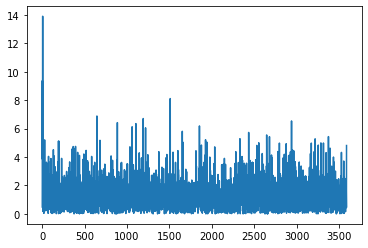

In [38]:
import matplotlib.pyplot as plt 

cs = torch.cumsum(torch.tensor(errs), dim=0)
ma = (cs[100:] - cs[:-100])/100.
#list(ma)
plt.plot(errs)
#plt.plot(stab)
plt.show()

## scratch space

$x_1, X_2, X_3, \ldots, X_{p-1}, x_p = y$

$\beta_1^F, \beta_1^B, \beta_2^F, \beta_2^B, \ldots, \beta_{p-1}^F, \beta_{p-1}^B$

$\hat x_{j+1} = \sigma \left( \beta_j^{FT} x_j \right)$

forward series: $x_1, \hat x_2, \hat x_3, \ldots, \hat x_{p-1}, x_p = y$

$ \hat \beta_{p-1}^{FT} = \text{argmin}_\beta \| x_p - \beta^{T} \hat x_{p-1} \|^2 $

$ \hat \beta_{p-2}^{FT} = \text{argmin}_\beta \| \hat x_{p-1} - \beta^{T} \hat x_{p-2} \|^2 $ We won't do this. 

$ \tilde x_{j-1} = \sigma^{-1}\left( \beta_j^{BT} x_j \right)$

backward series: $x_1, \tilde x_2, \tilde x_3, \ldots, \tilde x_{p-1}, x_p = y$

$ \hat \beta_{p-2}^{F} = \text{argmin}_\beta \| \tilde x_{p-1} - \beta^{T} \hat x_{p-2} \|^2 $

$ \hat \beta_{p-2}^{B} = \text{argmin}_\beta \| \hat x_{p-2} - \beta^{T} \tilde x_{p-1} \|^2 $

$ \hat x_3 = \sigma \left( \beta_2^{FT} \hat x_2 \right) $

$ \hat \beta_2^F = \text{argmin}_\beta \| \sigma^{-1}\left( \hat x_3 \right) - \beta^T \hat x_2 \|^2 $ Useless without $\tilde x$

$ \tilde x_2 = \sigma^{-1}\left( \beta_3^{BT} \tilde x_3 \right) $

$ \hat \beta_2^B = \text{argmin}_\beta \| \sigma\left( \hat x_2 \right) - \beta^T \hat x_3 \|^2 $ Useless without $\hat x$

So, use these estimates instead.

$ \hat \beta_2^F = \text{argmin}_\beta \| \sigma^{-1}\left( \tilde x_3 \right) - \beta^T \hat x_2 \|^2 $

$ \hat \beta_2^B = \text{argmin}_\beta \| \sigma\left( \hat x_2 \right) - \beta^T \tilde x_3 \|^2 $

$\mathbb{E} l(X;\theta) \approx l(X;\theta_0) + \left( \theta - \theta_0 \right)^T \mathbb{E} \nabla_\theta l(X;\theta_0) + \left( \theta - \theta_0 \right)^T \mathbb{E} \nabla^2_\theta l(X;\theta_0) \left( \theta - \theta_0 \right)/2 $

$ = \mathbb{E}l(X;\theta_0) + 0 - \left( \theta - \theta_0 \right)^T \mathcal{I}_{\theta_0} \left( \theta - \theta_0 \right)/2 $


$ X_{j+1} = \beta^T X_j + \sigma \varepsilon, \; \varepsilon \sim N(0, \mathcal{I}) $

$ X_{j+k} = \beta^{kT} X_j \Rightarrow \mathbb{E}[X_j|X_0] = \mathbb{E}[\beta^{jT} X_0|X_0] = \beta^{jT} X_0 $

$ \mathbb{E}\left[ f(X_0) \; | \; X_0 \right] = f(X_0) $